In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from   torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:


def SNR(x_ref,x):
    x_ref_vect = x_ref.flatten()
    x_vect = x.flatten()
    res=-20*np.log10(np.linalg.norm(x_ref_vect-x_vect)/np.linalg.norm(x_vect)+1e-15)
    return res

In [3]:
# parameters

I_WIDTH=I_HEIGTH=96
N_CHANNELS=1
I_SIZE=I_WIDTH*I_HEIGTH*N_CHANNELS
encode_size=int(I_SIZE/10)
             
batch_size=128

In [9]:
# Telecharger le jeu d'entrainement et de test

transform = transforms.Compose(
    [transforms.Grayscale(1),
     transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', transform=transform,download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size,shuffle=True, num_workers=2)
testset = torchvision.datasets.STL10(root='./data', split='test', transform=transform,download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size,shuffle=False, num_workers=2)
     

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Architecture de l'encoder

class Auto_Encoder(nn.Module):
    def __init__(self,code_size):
        super(Auto_Encoder,self).__init__()
        
        self.code_size = code_size
        self.encode0=nn.Sequential(
            nn.Conv2d(N_CHANNELS,20,9),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(20,30,9),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self._fc1encoder=nn.Linear(30*18*18,5000)
        self._fc2encoder=nn.Linear(5000,self.code_size)
        self._fc1decoder=nn.Linear(self.code_size,5000)
        self._fc2decoder=nn.Linear(5000,I_SIZE)
        
    def encode(self,x_0):
        x=self.encode0(x_0)
        x = x.view(-1,30*18*18)
        x = F.relu(self._fc1encoder(x))
        x = self._fc2encoder(x)
        return x
    
    def decode(self,x_0):
        x=F.relu(self._fc1decoder(x_0))
        x=torch.sigmoid(self._fc2decoder(x))
        x=x.view([x_0.size(0),N_CHANNELS,I_WIDTH,I_HEIGTH])
        return x
    def forward(self,x):
        encode=self.encode(x)
        decode=self.decode(encode)
        return decode
    


In [11]:
AE=Auto_Encoder(encode_size).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(AE.parameters(), lr=0.001)
items=len(trainloader)


In [42]:
## APPRENTISSAGE
n_epochs=50
loss_history=[] #To track the evolution of loss
for j in range(n_epochs): 
    running_loss=0
    print("epoch n %.2f"%j)
    for i,(data, _) in enumerate(trainloader):
        
        # zero the parameter gradients
        optimizer.zero_grad()

        data=data.cuda()
        output = AE(data)
        loss = criterion(output, data)
        #loss_history.append(loss.data[0])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%(items/5)-1==0:
            print("%.3f"%(i*100/items) + " done")
    print("Avg loss for this epoch : %.5f"%(running_loss/items))
    loss_history.append(running_loss/items)

epoch n 0.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00427
epoch n 1.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00417
epoch n 2.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00410
epoch n 3.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00382
epoch n 4.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00372
epoch n 5.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00366
epoch n 6.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00362
epoch n 7.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00394
epoch n 8.00
2.500 done
22.500 done
42.500 done
62.500 done
82.500 done
Avg loss for this epoch : 0.00362
epoch n 9.00
2.500 done
22.500 done
42.500 don

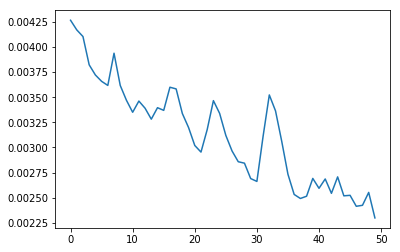

In [43]:
plt.plot(loss_history)
plt.show()

SNR: 21.278357


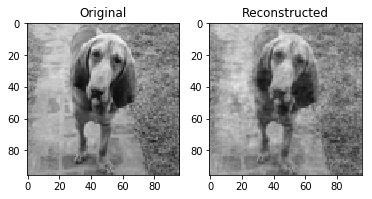

In [57]:
import random

Ratio=10
while Ratio < 20:
    test_image = random.choice(testset)[0]
    test_image = test_image.view([1, 1, I_WIDTH, I_HEIGTH])
    test_reconst = AE(test_image.cuda())
    
    Ratio=SNR(test_image.cpu().detach().numpy(),test_reconst.cpu().detach().numpy())



print("SNR: %4f" %Ratio)
torchvision.utils.save_image(test_image.data, 'orig.png')
torchvision.utils.save_image(test_reconst.data, 'reconst.png')
OG= mpimg.imread("orig.png",format="png")
Reconst=mpimg.imread("reconst.png",format="png")
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(OG)
plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(Reconst)
plt.show()

In [41]:
import pickle
pickle.dump(AE,open('./test.pth','wb'))
